In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from exceptions.Exceptions import ModelNotFoundException
from models import *
from models.custom_data_parallel import CustomDataParallel
from loguru import logger
from torch.autograd import Variable
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn import svm


In [2]:
# imports

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
trainloader = None
testloader = None
learning_rate = 0.01
ckpt_path = "./checkpoint/"

models = {
        "RegNetX_200MF": RegNetX_200MF(),
        "VGG": VGG('VGG19'),
        "ResNet18": ResNet18(),
        "PreActResNet18": PreActResNet18(),
        "GoogLeNet": GoogLeNet(),
        "DenseNet121": DenseNet121(),
        "ResNeXt29_2x64d": ResNeXt29_2x64d(),
        "MobileNet": MobileNet(),
        "MobileNetV2": MobileNetV2(),
        "DPN92": DPN92(),
#        "ShuffleNetG2": ShuffleNetG2(),
        "SENet18": SENet18(),
#        "ShuffleNetV2": ShuffleNetV2(),
        "EfficientNetB0": EfficientNetB0()
    }

# Some hyperparams
model_name = 'RegNetX_200MF'
net = models[model_name]
num_epochs = 15
start_epoch = 0
learning_rate = 0.01
train_batch_size = 128
test_batch_size = 100


# Set up parameters and optimizer

In [3]:
# Set up optimizer
learning_rate = learning_rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate,
                    momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                    step_size=10.0, gamma=0.1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ckpt_path = ckpt_path + model_name + ".torch"
num_epochs = num_epochs
net = net.to(device)
if device == 'cuda':
    net = CustomDataParallel(net)
    cudnn.benchmark = True

<class 'torch.nn.parallel.data_parallel.DataParallel'>


## Prepare data

In [4]:
logger.info('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, shuffle=True, num_workers=2)

2020-11-15 15:19:57.734 | INFO     | __main__:<module>:1 - ==> Preparing data..


Files already downloaded and verified
Files already downloaded and verified


## Train and test functions, and start training

In [5]:
def train(epoch):
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        log_interval = 10
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + loss.item()
            _, predicted = outputs.max(1)
            total = total + targets.size(0)
            
            max_logit = outputs.data.max(1, keepdim=True)[1]
            correct = max_logit.eq( targets.data.view_as(max_logit) ).sum()
            processed = ((batch_idx + 1) * train_batch_size)
            
            accuracy = (100. * correct) / train_batch_size
            progress = (100. * processed) / len(trainset)

            if (batch_idx + 1) % log_interval == 0: 
                    logger.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLocal Loss: {:.6f}\t Accuracy: {:.6f}\t', 
                    epoch, processed, len(trainset), progress, loss.item(), accuracy)


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0.0
    total = 0
    acc = 0

    with torch.no_grad():
        for _, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc = 100.*correct/total

        logger.info('Test set: loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(loss.item(), correct, len(testset), acc))  

        if acc > best_acc:
            print('Saving..')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            
            logger.info( 'Saving/Serving model: epoch: {}, loss: {}, path: {}', epoch, loss.item(), './checkpoint' )
            torch.save( {'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()}, ckpt_path)
            best_acc = acc

def train_model(start_epoch):
    for epoch in range(start_epoch, start_epoch+num_epochs):
        train(epoch)
        scheduler.step()
        test(epoch)

# Start training model...
#train_model(0)

In [6]:
checkpoint = torch.load(ckpt_path)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
#net.eval()

In [11]:

# Let's grab the test set and input it through the model, 
# and train an SVM on the output of the final layer. 

# Principal component analysis.
pca = PCA(n_components=2)
X = []
Y = []
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        correct = 0
        inputs, targets = inputs.to(device), targets.to(device)
        
        for input, target in zip(inputs, targets):
            output = net(input.unsqueeze(0))
            
            predicted = output.data.max(1, keepdim=True)[1]
            if torch.eq(predicted, target):
                # Samples correctly classified, let's grab the output of the last layer 
                # to input it into the SVM.
                final_layer_output = net.final_layer_output
                final_layer_output = final_layer_output.view(-1, 23552)
                final_layer_output = final_layer_output.tolist()
                X.extend(final_layer_output)
                Y.append(target.cpu().numpy())

            
# Transform using PCA to only 2 features 
# (probably a bad idea, but let's see what happens)
X = pca.fit_transform(X)

In [34]:
lin_clf = SVC(decision_function_shape='ovr', C=10,gamma=0.00001)
lin_clf.fit(X, Y)

SVC(C=10, gamma=1e-05)

ValueError: Unrecognized marker style 'q'

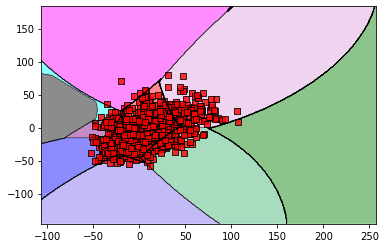

In [41]:
X = np.array(X)
Y = np.array(Y)
plot_decision_regions(X, Y, clf=lin_clf, legend=4, 
                      colors='red,green,blue,purple,cyan,black,mediumslateblue,magenta,mediumseagreen,plum',
                      markers='square,circle,diamond,star,triangle_up,triangle_down,x,triangle_right,triangle_left,plus')
plt.show()